## Reading the data

In [16]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

df = pd.read_csv("../../corpus_sprint2_balanced_cps.csv", encoding="utf-8")
df = df.dropna()

model = Doc2Vec.load("../../model_doc2vec_balanced_20epochs")

## One hot encoding and concatenating

In [17]:
vectors = model.docvecs.vectors_docs

In [18]:
#print(df)
one_hot = pd.Categorical(df['Product'])
df_dummies = pd.get_dummies(one_hot)

one_hot2 = pd.Categorical(df['Sub-product'])
df_dummies2 = pd.get_dummies(one_hot2)

v_df = pd.DataFrame(vectors)
df_concat = pd.concat([v_df, df_dummies, df_dummies2], axis = 1)
print(df_concat)

               0         1         2         3         4         5         6  \
0      -0.206502 -0.089569 -0.479192 -0.607455  0.441230 -0.835218  0.229955   
1      -0.199045  0.245777 -0.058751 -0.922997  0.417415 -0.339759 -0.466736   
2      -0.117612 -0.230441  0.104659 -0.059141  0.244450 -0.532243 -0.273285   
3      -0.056852 -0.428939 -0.503455  0.431379 -0.107010 -0.341381 -1.130548   
4      -0.144027 -0.137468 -0.196015 -0.340400  0.788206 -0.180849 -0.526431   
...          ...       ...       ...       ...       ...       ...       ...   
111629  0.475766  0.044374 -0.918518 -0.464938  0.257347 -0.190196 -0.419938   
111630 -0.492041 -0.346752 -0.051855  0.526952  0.830449 -0.631116 -0.493316   
111631  0.082189  0.002191  0.222593  0.533906  0.391737  0.046392 -0.482322   
111632  0.238248 -0.162442  0.073858  0.188567  0.301132 -0.020022 -0.073487   
111633 -0.241412 -0.182984 -0.777466  0.257785  0.239757 -0.851278 -0.222554   

               7         8         9  .

## Applying k-means

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics

### Visual with elbow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


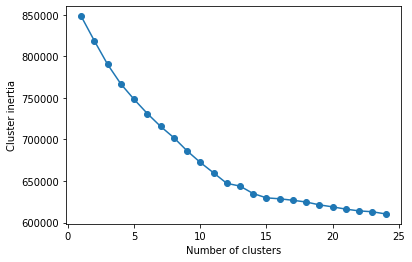

In [20]:
inertia = []
k_min=1
k_max=25
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(df_concat)
    inertia.append(km.inertia_)

plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

### Automatic with silhouette

In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(vectors) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vectors)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vectors, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vectors, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(vectors[:, 0], vectors[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Cluster id labels for inputted data
[10 10  9 ...  2  2  2]
Centroids data
[[-9.41108465e-02 -6.63759485e-02  4.05852497e-03 ...  1.01494633e-01
   5.42341232e-01  3.22237611e-07]
 [ 8.74562338e-02 -1.26733795e-01  6.56391978e-02 ... -3.42726707e-07
   1.12131238e-06 -3.25031579e-07]
 [-8.47055763e-02 -1.90559983e-01 -1.50422245e-01 ... -2.15228647e-06
  -9.95770097e-06  3.36393714e-06]
 ...
 [ 1.36877149e-02 -2.29628161e-01  1.06096394e-01 ...  4.47034836e-08
   1.08405948e-06 -3.17580998e-07]
 [-9.47597623e-02 -1.66136533e-01 -1.96348518e-01 ... -7.62753189e-07
   1.13993883e-06  2.78465450e-07]
 [ 8.76927152e-02 -3.11491728e-01 -5.41926622e-02 ... -6.62170351e-07
   1.13621354e-06  4.37721610e-08]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-644177.7
